# 1. fake image 판별

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import cv2
import math
from operator import itemgetter

In [2]:
# 원본 이미지들
imgs = ['000.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg']

# Task 1. 푸리에 변환

In [3]:
# fourier transform
def FT(image_file_name):
    
    #a. change image to gray color
    img = cv2.imread(image_file_name, cv2.IMREAD_COLOR)
    gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
    
    #b. find fourier transform of image
    M, N = len(gray), len(gray[0])
    rows = np.array([[np.exp(-2j * np.pi * m * u / M) for m in range(M)] for u in range(M)])
    cols = np.array([[np.exp(-2j * np.pi * n * v / N) for v in range(N)] for n in range(N)])
    img_ft = np.matmul(rows, np.matmul(gray, cols))

    return img_ft

def magnitude_spectrum(img):
    a = np.fft.fftshift(img)
    return 20*np.log(np.abs(a))

In [4]:
fourier_transform_of_img = [FT(img) for img in imgs]

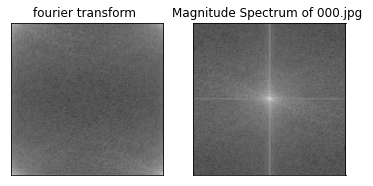

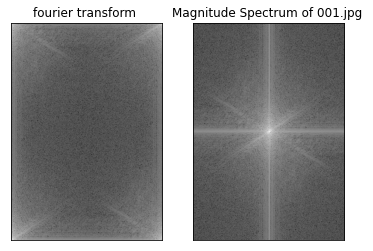

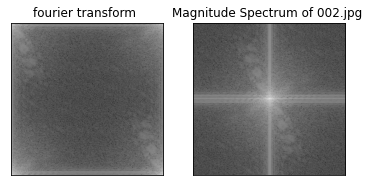

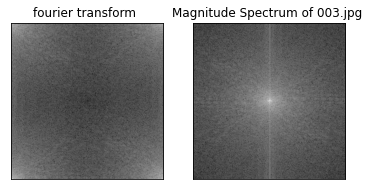

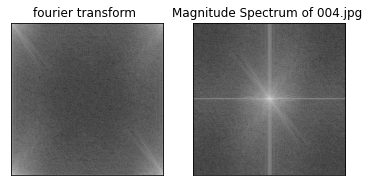

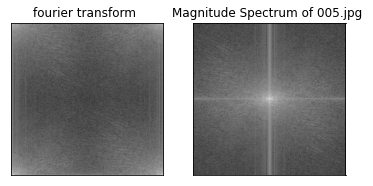

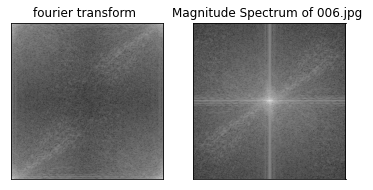

In [5]:
for i in range(len(fourier_transform_of_img)):
    spectrum = magnitude_spectrum(fourier_transform_of_img[i])

    plt.subplot(1,2,1), plt.imshow(np.log(np.abs(fourier_transform_of_img[i])), cmap='gray')
    plt.title('fourier transform '), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2), plt.imshow(spectrum, cmap='gray')
    plt.title('Magnitude Spectrum of {} '.format(imgs[i])), plt.xticks([]), plt.yticks([])
    plt.show()
    

# Task 2. Azimuthal averaging

In [6]:
def AA(img):
    #a. center
    center = [len(img[0])//2, len(img)//2]

    def distance_from_center(x, y):
        return int(math.sqrt( pow(x-center[0], 2) + pow(y-center[1], 2) ))

    #b ~ c-a) 픽셀들의 distance 계산하고 인덱스 저장하기
    rows, cols = len(img), len(img[0])
    distance_row_col = np.zeros(shape = (rows*cols, 3), dtype=int)
    for row in range(rows):
        for col in range(cols):
            distance_row_col[row*cols + col][0] = distance_from_center(row, col)
            distance_row_col[row*cols + col][1] = row
            distance_row_col[row*cols + col][2] = col
    
    # distance를 기준으로 정렬
    distance_row_col = sorted(distance_row_col, key=lambda l : l[0])
    
    # c-b) type casting 
    
    # d-a) make list of freq power values(픽셀 값) same in the order of sorted distance
    freq = np.zeros(shape=len(distance_row_col))
    for i in range(len(distance_row_col)):
        freq[i] = img[ distance_row_col[i][1] ][ distance_row_col[i][2] ]
    
    max_distance = distance_row_col[-1][0]
    number_of_pixels = np.zeros(shape = max_distance+1, dtype=int)
    
    # d-b) cumulate. (해당하는 반지름 안에)
    sum_of_freq_in_radius = np.zeros(shape = max_distance+1)
    for i in range(len(freq)):
        if distance_row_col[i][0] == 0:
            continue
        sum_of_freq_in_radius[distance_row_col[i][0]] += freq[i]
        number_of_pixels[distance_row_col[i][0]] += 1
        
    # e-a) to integer => 왜?
    sum_of_freq_in_radius = np.array([int(i) for i in sum_of_freq_in_radius])
    
    #e-b) 
    # e-b) sum
        
    # e-c) divide with pixels in each radius
    result = np.zeros(shape = max_distance)
    for i in range(1, len(sum_of_freq_in_radius)):
        result[i-1] = sum_of_freq_in_radius[i] / number_of_pixels[i]
    
    # f-c) devide all average value with the max average value
    max_avg = max(result)
    result /= max_avg
    
    return result

In [7]:
list_of_F = []
for i in fourier_transform_of_img:
    list_of_F.append(AA(magnitude_spectrum(i)))

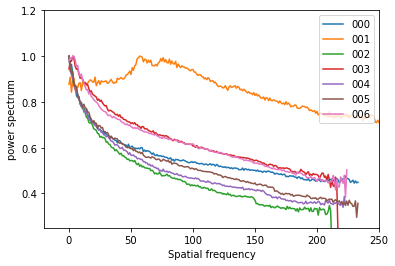

In [8]:
count=0
for i in list_of_F:
    x = np.arange(len(i))
    plt.plot(x, i, label = '00'+str(count))
    count+=1

plt.legend()
plt.xlim(-20, 250); plt.ylim(0.25, 1.2)
plt.xlabel('Spatial frequency'); plt.ylabel('power spectrum')
plt.show()

# Task 3

In [9]:
#2. inverse fourier transform
def inv_FT(img):
    M, N = len(img), len(img[0])
    img /= M*N
    
    #b. find inverse fourier transform of image
    M, N = len(img), len(img[0])
    rows = np.array([[np.exp(2j * np.pi * m * u / M) for m in range(M)] for u in range(M)])
    cols = np.array([[np.exp(2j * np.pi * n * v / N) for v in range(N)] for n in range(N)])

    return np.matmul(rows, np.matmul(img, cols))

def high_pass_filter(img_ft):
    M, N = len(img_ft), len(img_ft[0])
    
    def distance_from_center(u, v):
        return math.sqrt(pow(u-M//2, 2)+pow(v-N//2, 2))
    
    re = np.zeros(shape = (M, N), dtype=complex)
    
    #필터링 기준 거리 설정
    rad = 45
    for u in range(M):
        for v in range(N):
            if distance_from_center(u, v) < rad:
                re[u][v] = 0
            else:
                re[u][v] = img_ft[u][v]
    
    return re

In [10]:
re = []
for i in fourier_transform_of_img:
    a = high_pass_filter(np.fft.fftshift(i))
    b = np.fft.fftshift(a)
    re.append(inv_FT(b))

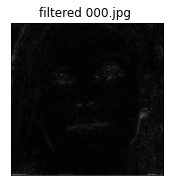

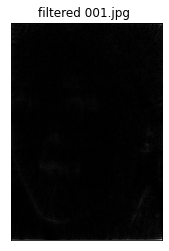

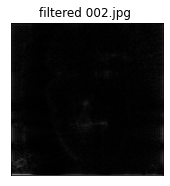

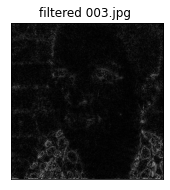

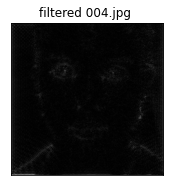

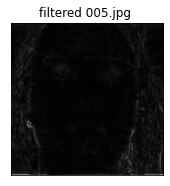

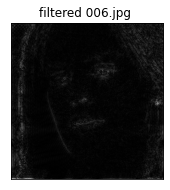

In [11]:
count=0
for i in range(len(re)):
    plt.subplot(1,2,1), plt.imshow(abs(re[i]), cmap='gray')
    plt.title('filtered 00{}.jpg '.format(count)), plt.xticks([]), plt.yticks([])
    count+=1
    plt.show()